### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import Settings
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType

#### Train the network

In [2]:
popsize = 10
generations = 100
name = 'hidden4'

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 2,
    n = 100,
    clusters = 80,
    cluster_size = 20,
    food_amount = 1000,
    scale = 4,
    wrap_around = True,
    model_type = ModelType.LocalOnly,
    env_type = EnvironmentType.Clusters,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 3,
    noise = 0.002,
    energy_required_to_replicate = 50,
)

In [3]:
#TODO ADD settings like number of clusters and food in clusters..., std of clusters..
trainer = Evo_Trainer(settings, popsize)
network = Conv(settings=settings)

2023-04-04 15:18:10,953	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-04 15:18:20] INFO     < 3103> evotorch.core: Instance of `Custom_NEProblem` (id:4354326192) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-04 15:18:20] INFO     < 3103> evotorch.core: Instance of `Custom_NEProblem` (id:4354326192) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-04 15:18:20] INFO     < 3103> evotorch.core: Instance of `Custom_NEProblem` (id:4354326192) -- The `device` of the problem is set as cpu
[2023-04-04 15:18:20] INFO     < 3103> evotorch.core: Instance of `Custom_NEProblem` (id:4354326192) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-04 15:18:20] INFO     < 3103> evotorch.core: Instance of `Custom_NEProblem` (id:4354326192) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [6]:
generations = 500

In [7]:
trainer.train(generations, name)

         iter : 257
     stepsize : ReadOnlyTensor(0.0326)
  median_eval : 17.731884002685547
pop_best_eval : 17.797101974487305
    mean_eval : 17.716665267944336

         iter : 258
     stepsize : ReadOnlyTensor(0.0326)
  median_eval : 45.06999969482422
pop_best_eval : 46.650001525878906
    mean_eval : 44.79349899291992

         iter : 259
     stepsize : ReadOnlyTensor(0.0326)
  median_eval : 73.02010345458984
pop_best_eval : 73.78894805908203
    mean_eval : 72.87236022949219

         iter : 260
     stepsize : ReadOnlyTensor(0.0326)
  median_eval : 67.078125
pop_best_eval : 67.078125
    mean_eval : 67.078125

         iter : 261
     stepsize : ReadOnlyTensor(0.0325)
  median_eval : 16.899999618530273
pop_best_eval : 20.899999618530273
    mean_eval : 16.70800018310547



In [8]:
network = trainer.get_trained_network()

In [9]:
#trainer.logger_df.from_csv('../logger/' + name + '.csv')
#network.load_state_dict(torch.load('../models/' + name + '.pth'))

In [10]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [11]:
#trainer.searcher.status

#### Visualize trained network

In [12]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network.batch_size = settings.batch_size
network(graph, 0)

DataBatch(x=[3400, 11], edge_index=[1, 0], device=[2], subsize=[2], velocity=[2], border_cost=[2], food_reward=[2], dead_cost=[2], visible_food=[2], food_avg_dist=[2], food_avg_degree=[2], food_search_movement=[2], batch=[3400], ptr=[3])

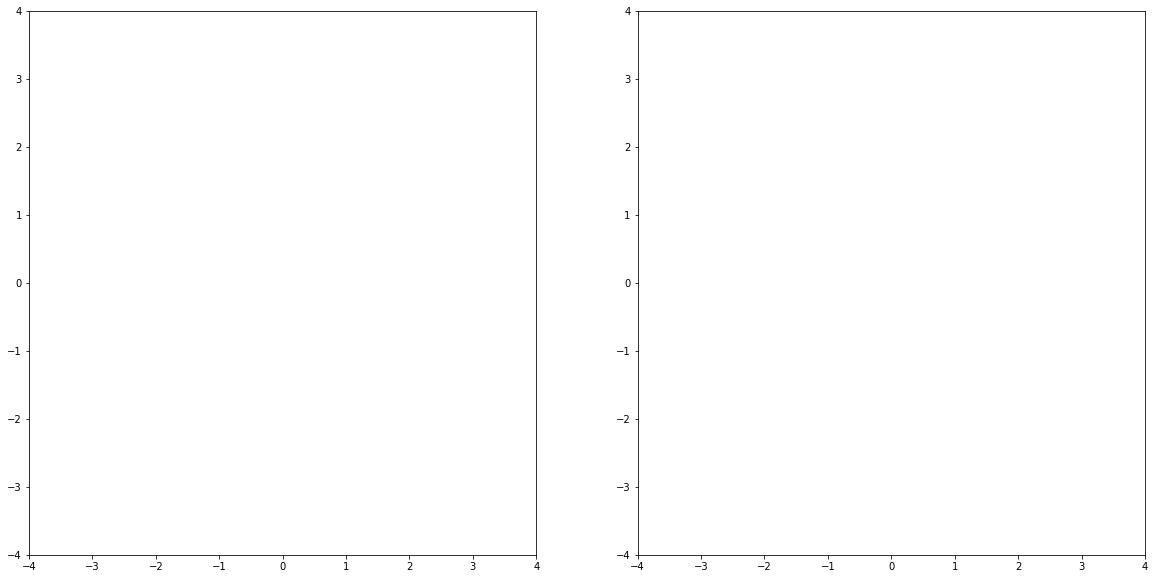

In [13]:
anim = visualizer.animate_organism(graph, network, food=30, frames=200) #test environment
#visualizer.save_animation_to_gif(anim, name, fps=10, dpi=200) #beautiful

#anim = visualizer.animate_organism(graph, network, food=30, frames=200) #visualize model
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=50) #fast

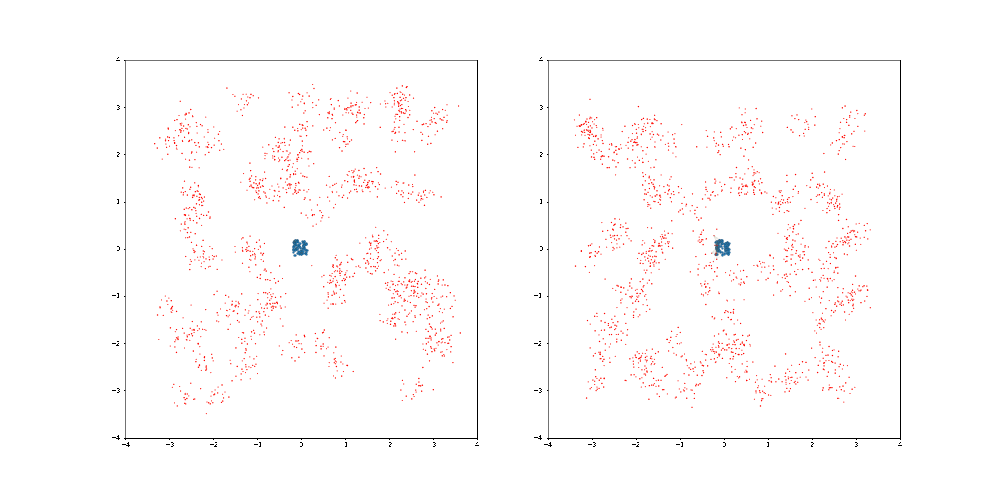

In [14]:
Image('../animation/' + name + '.gif')

In [15]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

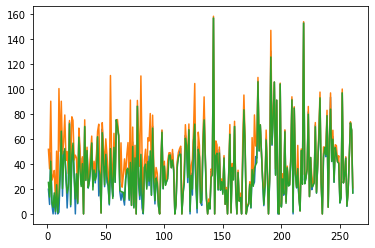

In [16]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()